<a href="https://colab.research.google.com/github/Equuleus0221/VisionToText/blob/main/RyanD'SouzaVisionToText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#Imports

import os
import random
import re
from collections import Counter
import torch
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
#Dataset class and Collate Function

class ImageCaptionDataset:
    def __init__(self, images_dir, captions_file, vocab_threshold=5, num_images=None):
        self.images_dir = images_dir
        self.vocab_threshold = vocab_threshold
        self.captions = self.load_captions(captions_file)
        if num_images is not None:
            all_image_ids = list(self.captions.keys())
            random.seed(42)
            selected_image_ids = set(random.sample(all_image_ids, num_images))
            self.captions = {img_id: caps for img_id, caps in self.captions.items() if img_id in selected_image_ids}
        self.vocabulary = self.build_vocabulary()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.samples = []
        for image_id, caption_list in self.captions.items():
            img_path = os.path.join(self.images_dir, image_id)
            if os.path.exists(img_path):
                for caption in caption_list:
                    self.samples.append((image_id, caption))
        if not self.samples:
            raise ValueError("No available (image,caption) samples after filtering.")

    def load_captions(self, captions_file):
        captions = {}
        with open(captions_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    image_tag, caption = parts
                    image_id = image_tag.split('#')[0]
                    caption = self.clean_caption(caption)
                    if image_id not in captions:
                        captions[image_id] = []
                    captions[image_id].append(caption)
        return captions

    def clean_caption(self, caption):
        caption = caption.lower()
        caption = re.sub(r'[^a-zA-Z\s]', '', caption)
        caption = '<start> ' + caption + ' <end>'
        return caption

    def build_vocabulary(self):
        word_counts = Counter()
        for caption_list in self.captions.values():
            for caption in caption_list:
                word_counts.update(caption.split())
        vocabulary = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
        for word, count in word_counts.items():
            if count >= self.vocab_threshold:
                vocabulary[word] = len(vocabulary)
        return vocabulary

    def caption_to_indices(self, caption):
        words = caption.split()
        return [self.vocabulary.get(word, self.vocabulary['<unk>']) for word in words]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_id, caption = self.samples[idx]
        img_path = os.path.join(self.images_dir, image_id)
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        caption_indices = self.caption_to_indices(caption)
        caption_tensor = torch.tensor(caption_indices, dtype=torch.long)
        return image, caption_tensor

def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    max_len = max([cap.size(0) for cap in captions])
    batch_size = len(captions)
    padded_captions = torch.zeros((batch_size, max_len), dtype=torch.long)
    for i, cap in enumerate(captions):
        end = cap.size(0)
        padded_captions[i, :end] = cap
    return images, padded_captions


In [8]:
#Model Code

import torchvision.models as models

class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.linear(features)
        features = self.bn(features)
        return features

class CaptionDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.0)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        caption_embeds = self.embed(captions)
        features = features.unsqueeze(1)
        inputs = torch.cat((features, caption_embeds), dim=1)
        lstm_out, _ = self.lstm(inputs)
        lstm_out = self.dropout(lstm_out)
        outputs = self.linear(lstm_out)
        return outputs

    def sample(self, features, max_length=20):
        inputs = features.unsqueeze(1)
        hidden = None
        sampled_ids = []
        for _ in range(max_length):
            hiddens, hidden = self.lstm(inputs, hidden)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.encoder = ImageEncoder(embed_size)
        self.decoder = CaptionDecoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        return self.decoder(features, captions)

    def generate_caption(self, image_tensor, vocabulary, max_length=20):
        self.eval()
        with torch.no_grad():
            features = self.encoder(image_tensor)
            sampled_ids = self.decoder.sample(features, max_length)
            sampled_ids = sampled_ids[0].cpu().numpy()
        inv_vocab = {v: k for k, v in vocabulary.items()}
        caption = []
        for idx in sampled_ids:
            word = inv_vocab.get(idx, '<unk>')
            if word == '<end>':
                break
            if word not in ['<start>', '<pad>']:
                caption.append(word)
        return ' '.join(caption)


In [9]:
#Training and Evaluation Code

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        print(f"Epoch {epoch+1}/{num_epochs}")
        total_train_loss = 0.0
        num_batches = 0
        for batch_idx, (images, captions) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            images = images.to(device)
            captions = captions.to(device)
            inputs = captions[:, :-1]
            targets = captions[:, 1:]
            outputs = model(images, inputs)
            outputs = outputs[:, :targets.size(1), :]
            outputs = outputs.reshape(-1, outputs.size(-1))
            targets = targets.reshape(-1)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            total_train_loss += loss.item()
            num_batches += 1
            if batch_idx % 5 == 0:
                print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")
        avg_train_loss = total_train_loss / num_batches
        print(f"Train Loss: {avg_train_loss:.4f} (no val)")

def compute_bleu_score(candidate_caption, reference_captions):
    candidate = candidate_caption.split()
    references = [ref.split() for ref in reference_captions]
    bleu1 = sentence_bleu(references, candidate, weights=(1,0,0,0))
    bleu4 = sentence_bleu(references, candidate, weights=(0.25,0.25,0.25,0.25))
    return bleu1, bleu4

def evaluate_bleu(model, dataset, num_samples=100):
    print(f"\nEvaluating BLEU on {num_samples} random images:")
    bleu1_total, bleu4_total = 0, 0
    sample_indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    for idx in sample_indices:
        image_id, _ = dataset.samples[idx]
        img_path = os.path.join(dataset.images_dir, image_id)
        image = Image.open(img_path).convert('RGB')
        image_tensor = dataset.transform(image).unsqueeze(0).to(next(model.parameters()).device)
        with torch.no_grad():
            generated_caption = model.generate_caption(image_tensor, dataset.vocabulary)
        references = dataset.captions[image_id]
        bleu1, bleu4 = compute_bleu_score(generated_caption, references)
        bleu1_total += bleu1
        bleu4_total += bleu4
    avg_bleu1 = bleu1_total / len(sample_indices)
    avg_bleu4 = bleu4_total / len(sample_indices)
    print(f"Avg BLEU-1: {avg_bleu1:.4f}  |  Avg BLEU-4: {avg_bleu4:.4f}")

def display_random_captions(model, dataset, num_images=5):
    model.eval()
    device = next(model.parameters()).device
    sample_indices = random.sample(range(len(dataset)), num_images)
    for idx in sample_indices:
        image_id, _ = dataset.samples[idx]
        img_path = os.path.join(dataset.images_dir, image_id)
        image = Image.open(img_path).convert('RGB')
        image_tensor = dataset.transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            generated_caption = model.generate_caption(image_tensor, dataset.vocabulary)
        actual_captions = dataset.captions.get(image_id, [])
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title("Generated: " + generated_caption, fontsize=12)
        actual_text = "\n".join(f"GT {i+1}: {c}" for i, c in enumerate(actual_captions))
        plt.figtext(0.5, 0.01, actual_text, wrap=True, horizontalalignment='center', fontsize=10)
        plt.show()


In [10]:
#Main Training Script

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
images_dir = '/content/drive/MyDrive/VisionToText/Flickr8k_Dataset/Flicker8k_Dataset'
captions_file = '/content/drive/MyDrive/VisionToText/Flickr8k_text/Flickr8k.token.txt'
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NUM_EPOCHS = 10
7
print("Loading dataset...")
dataset = ImageCaptionDataset(
    images_dir=images_dir,
    captions_file=captions_file,
    vocab_threshold=5,
    num_images=2000
)
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)
vocab_size = len(dataset.vocabulary)
model = ImageCaptioningModel(
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    vocab_size=vocab_size,
    num_layers=NUM_LAYERS
)
print(f"Model initialized with vocab size: {vocab_size}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
train_model(model, train_loader, val_loader=None, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Loading dataset...
Model initialized with vocab size: 1355
Total parameters: 26,652,043
Epoch 1/10


Epoch 1:   1%|          | 2/313 [00:16<34:16,  6.61s/it]  

Batch 0, Loss: 7.2081


Epoch 1:   2%|▏         | 6/313 [00:46<34:42,  6.78s/it]

Batch 5, Loss: 6.4525


Epoch 1:   4%|▍         | 12/313 [01:30<31:40,  6.31s/it]

Batch 10, Loss: 5.4548


Epoch 1:   5%|▌         | 16/313 [01:58<28:43,  5.80s/it]

Batch 15, Loss: 5.3490


Epoch 1:   7%|▋         | 22/313 [02:33<23:29,  4.84s/it]

Batch 20, Loss: 5.2526


Epoch 1:   8%|▊         | 26/313 [02:56<23:14,  4.86s/it]

Batch 25, Loss: 5.0299


Epoch 1:  10%|▉         | 31/313 [03:28<31:47,  6.77s/it]

Batch 30, Loss: 5.0321


Epoch 1:  12%|█▏        | 36/313 [03:48<20:06,  4.35s/it]

Batch 35, Loss: 4.9030


Epoch 1:  13%|█▎        | 42/313 [04:15<16:59,  3.76s/it]

Batch 40, Loss: 4.9140


Epoch 1:  15%|█▍        | 46/313 [04:35<17:52,  4.02s/it]

Batch 45, Loss: 4.9443


Epoch 1:  17%|█▋        | 52/313 [04:58<14:59,  3.45s/it]

Batch 50, Loss: 4.7455


Epoch 1:  18%|█▊        | 56/313 [05:15<14:52,  3.47s/it]

Batch 55, Loss: 4.8262


Epoch 1:  20%|█▉        | 62/313 [05:37<12:23,  2.96s/it]

Batch 60, Loss: 4.6461


Epoch 1:  21%|██        | 66/313 [05:49<10:21,  2.52s/it]

Batch 65, Loss: 4.5184


Epoch 1:  23%|██▎       | 72/313 [06:02<07:19,  1.82s/it]

Batch 70, Loss: 4.6553


Epoch 1:  24%|██▍       | 76/313 [06:19<12:24,  3.14s/it]

Batch 75, Loss: 4.6487


Epoch 1:  26%|██▌       | 82/313 [06:34<07:52,  2.05s/it]

Batch 80, Loss: 4.5093


Epoch 1:  27%|██▋       | 86/313 [06:48<10:05,  2.67s/it]

Batch 85, Loss: 4.4852


Epoch 1:  29%|██▉       | 92/313 [06:59<05:53,  1.60s/it]

Batch 90, Loss: 4.4674


Epoch 1:  31%|███       | 96/313 [07:06<05:32,  1.53s/it]

Batch 95, Loss: 4.6997


Epoch 1:  33%|███▎      | 102/313 [07:16<05:17,  1.50s/it]

Batch 100, Loss: 4.5397


Epoch 1:  34%|███▍      | 106/313 [07:22<04:36,  1.33s/it]

Batch 105, Loss: 4.3589


Epoch 1:  35%|███▌      | 111/313 [07:28<03:13,  1.05it/s]

Batch 110, Loss: 4.3478


Epoch 1:  37%|███▋      | 116/313 [07:36<04:34,  1.40s/it]

Batch 115, Loss: 4.1405


Epoch 1:  39%|███▊      | 121/313 [07:43<03:26,  1.07s/it]

Batch 120, Loss: 4.3792


Epoch 1:  41%|████      | 127/313 [07:52<03:40,  1.19s/it]

Batch 125, Loss: 4.2959


Epoch 1:  42%|████▏     | 131/313 [07:55<01:52,  1.62it/s]

Batch 130, Loss: 4.0770


Epoch 1:  44%|████▍     | 137/313 [08:00<02:21,  1.25it/s]

Batch 135, Loss: 4.3619


Epoch 1:  45%|████▌     | 142/313 [08:05<02:01,  1.41it/s]

Batch 140, Loss: 4.3353


Epoch 1:  47%|████▋     | 146/313 [08:10<02:35,  1.07it/s]

Batch 145, Loss: 3.9676


Epoch 1:  49%|████▊     | 152/313 [08:15<01:57,  1.37it/s]

Batch 150, Loss: 4.2546


Epoch 1:  50%|█████     | 157/313 [08:18<01:24,  1.84it/s]

Batch 155, Loss: 4.4240


Epoch 1:  51%|█████▏    | 161/313 [08:21<01:23,  1.81it/s]

Batch 160, Loss: 4.2621


Epoch 1:  53%|█████▎    | 167/313 [08:26<01:36,  1.51it/s]

Batch 165, Loss: 4.2507


Epoch 1:  55%|█████▍    | 171/313 [08:29<01:13,  1.92it/s]

Batch 170, Loss: 4.2347


Epoch 1:  56%|█████▌    | 176/313 [08:32<01:08,  1.99it/s]

Batch 175, Loss: 4.2915


Epoch 1:  58%|█████▊    | 182/313 [08:34<00:31,  4.13it/s]

Batch 180, Loss: 4.1871


Epoch 1:  59%|█████▉    | 186/313 [08:35<00:41,  3.08it/s]

Batch 185, Loss: 4.1544


Epoch 1:  61%|██████▏   | 192/313 [08:39<00:48,  2.51it/s]

Batch 190, Loss: 4.1676


Epoch 1:  63%|██████▎   | 197/313 [08:42<00:45,  2.58it/s]

Batch 195, Loss: 4.2016


Epoch 1:  64%|██████▍   | 201/313 [08:43<00:38,  2.87it/s]

Batch 200, Loss: 4.0669


Epoch 1:  66%|██████▌   | 207/313 [08:44<00:21,  4.88it/s]

Batch 205, Loss: 3.9397


Epoch 1:  67%|██████▋   | 211/313 [08:46<00:28,  3.61it/s]

Batch 210, Loss: 4.1549


Epoch 1:  69%|██████▉   | 217/313 [08:47<00:20,  4.64it/s]

Batch 215, Loss: 4.1003


Epoch 1:  71%|███████   | 221/313 [08:48<00:18,  4.87it/s]

Batch 220, Loss: 4.0348


Epoch 1:  73%|███████▎  | 227/313 [08:49<00:17,  4.99it/s]

Batch 225, Loss: 3.9972


Epoch 1:  74%|███████▍  | 231/313 [08:51<00:21,  3.77it/s]

Batch 230, Loss: 4.1778


Epoch 1:  76%|███████▌  | 237/313 [08:53<00:31,  2.42it/s]

Batch 235, Loss: 4.6060


Epoch 1:  77%|███████▋  | 241/313 [08:54<00:18,  3.90it/s]

Batch 240, Loss: 4.1857


Epoch 1:  79%|███████▉  | 247/313 [08:56<00:16,  4.12it/s]

Batch 245, Loss: 4.3205


Epoch 1:  81%|████████  | 252/313 [08:57<00:15,  3.84it/s]

Batch 250, Loss: 3.9207


Epoch 1:  82%|████████▏ | 256/313 [08:58<00:12,  4.70it/s]

Batch 255, Loss: 3.8686


Epoch 1:  84%|████████▎ | 262/313 [08:59<00:10,  4.70it/s]

Batch 260, Loss: 4.0671


Epoch 1:  85%|████████▍ | 266/313 [09:00<00:09,  4.83it/s]

Batch 265, Loss: 3.8392


Epoch 1:  87%|████████▋ | 272/313 [09:01<00:08,  4.76it/s]

Batch 270, Loss: 4.1674


Epoch 1:  88%|████████▊ | 276/313 [09:03<00:09,  4.07it/s]

Batch 275, Loss: 3.9372


Epoch 1:  90%|█████████ | 282/313 [09:05<00:08,  3.46it/s]

Batch 280, Loss: 4.1310


Epoch 1:  91%|█████████▏| 286/313 [09:06<00:08,  3.19it/s]

Batch 285, Loss: 4.0017


Epoch 1:  93%|█████████▎| 292/313 [09:08<00:04,  4.25it/s]

Batch 290, Loss: 3.9618


Epoch 1:  95%|█████████▍| 296/313 [09:09<00:03,  4.51it/s]

Batch 295, Loss: 4.0873


Epoch 1:  96%|█████████▋| 302/313 [09:10<00:02,  4.57it/s]

Batch 300, Loss: 3.7779


Epoch 1:  98%|█████████▊| 306/313 [09:11<00:01,  4.75it/s]

Batch 305, Loss: 3.9187


Epoch 1: 100%|█████████▉| 312/313 [09:12<00:00,  5.26it/s]

Batch 310, Loss: 3.9226


Epoch 1: 100%|██████████| 313/313 [09:12<00:00,  1.77s/it]


Train Loss: 4.4222 (no val)
Epoch 2/10


Epoch 2:   1%|          | 2/313 [00:00<01:45,  2.96it/s]

Batch 0, Loss: 3.7171


Epoch 2:   2%|▏         | 6/313 [00:01<01:08,  4.45it/s]

Batch 5, Loss: 4.1340


Epoch 2:   4%|▍         | 12/313 [00:03<01:04,  4.66it/s]

Batch 10, Loss: 3.7263


Epoch 2:   5%|▌         | 16/313 [00:03<00:59,  4.95it/s]

Batch 15, Loss: 3.8654


Epoch 2:   7%|▋         | 22/313 [00:05<01:29,  3.27it/s]

Batch 20, Loss: 3.7469


Epoch 2:   8%|▊         | 26/313 [00:07<01:27,  3.26it/s]

Batch 25, Loss: 3.9658


Epoch 2:  10%|█         | 32/313 [00:08<01:06,  4.20it/s]

Batch 30, Loss: 3.7851


Epoch 2:  12%|█▏        | 36/313 [00:09<00:58,  4.78it/s]

Batch 35, Loss: 3.9311


Epoch 2:  13%|█▎        | 42/313 [00:11<00:56,  4.76it/s]

Batch 40, Loss: 4.0448


Epoch 2:  15%|█▍        | 46/313 [00:12<00:54,  4.93it/s]

Batch 45, Loss: 3.5510


Epoch 2:  17%|█▋        | 52/313 [00:13<00:57,  4.54it/s]

Batch 50, Loss: 3.9805


Epoch 2:  18%|█▊        | 56/313 [00:14<00:56,  4.58it/s]

Batch 55, Loss: 3.9588


Epoch 2:  20%|█▉        | 62/313 [00:15<00:51,  4.85it/s]

Batch 60, Loss: 3.7237


Epoch 2:  21%|██        | 66/313 [00:16<00:54,  4.56it/s]

Batch 65, Loss: 3.7378


Epoch 2:  23%|██▎       | 72/313 [00:18<00:48,  4.92it/s]

Batch 70, Loss: 3.9349


Epoch 2:  24%|██▍       | 76/313 [00:19<01:08,  3.44it/s]

Batch 75, Loss: 3.8814


Epoch 2:  26%|██▌       | 82/313 [00:21<01:10,  3.29it/s]

Batch 80, Loss: 3.7759


Epoch 2:  27%|██▋       | 86/313 [00:22<00:52,  4.33it/s]

Batch 85, Loss: 3.6763


Epoch 2:  29%|██▉       | 92/313 [00:23<00:47,  4.66it/s]

Batch 90, Loss: 3.8622


Epoch 2:  31%|███       | 96/313 [00:24<00:46,  4.65it/s]

Batch 95, Loss: 3.8300


Epoch 2:  33%|███▎      | 102/313 [00:26<00:43,  4.85it/s]

Batch 100, Loss: 3.7816


Epoch 2:  34%|███▍      | 106/313 [00:27<00:44,  4.60it/s]

Batch 105, Loss: 3.6809


Epoch 2:  36%|███▌      | 112/313 [00:28<00:41,  4.84it/s]

Batch 110, Loss: 3.8178


Epoch 2:  37%|███▋      | 116/313 [00:29<00:42,  4.67it/s]

Batch 115, Loss: 3.9180


Epoch 2:  39%|███▉      | 122/313 [00:31<00:41,  4.56it/s]

Batch 120, Loss: 3.9205


Epoch 2:  40%|████      | 126/313 [00:32<00:43,  4.33it/s]

Batch 125, Loss: 3.7784


Epoch 2:  42%|████▏     | 132/313 [00:34<00:54,  3.33it/s]

Batch 130, Loss: 4.1798


Epoch 2:  43%|████▎     | 136/313 [00:35<00:52,  3.38it/s]

Batch 135, Loss: 3.7704


Epoch 2:  45%|████▌     | 142/313 [00:36<00:36,  4.72it/s]

Batch 140, Loss: 3.8081


Epoch 2:  47%|████▋     | 146/313 [00:37<00:34,  4.89it/s]

Batch 145, Loss: 3.8191


Epoch 2:  49%|████▊     | 152/313 [00:39<00:33,  4.82it/s]

Batch 150, Loss: 3.8159


Epoch 2:  50%|████▉     | 156/313 [00:40<00:32,  4.86it/s]

Batch 155, Loss: 4.0859


Epoch 2:  52%|█████▏    | 162/313 [00:41<00:32,  4.70it/s]

Batch 160, Loss: 3.7390


Epoch 2:  53%|█████▎    | 166/313 [00:42<00:29,  4.98it/s]

Batch 165, Loss: 3.9562


Epoch 2:  55%|█████▍    | 172/313 [00:43<00:28,  4.90it/s]

Batch 170, Loss: 3.9086


Epoch 2:  56%|█████▌    | 176/313 [00:44<00:29,  4.71it/s]

Batch 175, Loss: 3.9232


Epoch 2:  58%|█████▊    | 182/313 [00:46<00:35,  3.68it/s]

Batch 180, Loss: 3.9807


Epoch 2:  59%|█████▉    | 186/313 [00:47<00:39,  3.21it/s]

Batch 185, Loss: 3.8210


Epoch 2:  61%|██████▏   | 192/313 [00:49<00:33,  3.64it/s]

Batch 190, Loss: 3.8632


Epoch 2:  63%|██████▎   | 196/313 [00:50<00:26,  4.38it/s]

Batch 195, Loss: 3.7330


Epoch 2:  65%|██████▍   | 202/313 [00:51<00:24,  4.47it/s]

Batch 200, Loss: 3.7240


Epoch 2:  66%|██████▌   | 206/313 [00:52<00:21,  5.02it/s]

Batch 205, Loss: 3.5873


Epoch 2:  68%|██████▊   | 212/313 [00:54<00:21,  4.72it/s]

Batch 210, Loss: 3.9215


Epoch 2:  69%|██████▉   | 216/313 [00:55<00:20,  4.63it/s]

Batch 215, Loss: 3.9126


Epoch 2:  71%|███████   | 222/313 [00:56<00:18,  4.86it/s]

Batch 220, Loss: 3.8356


Epoch 2:  72%|███████▏  | 226/313 [00:57<00:18,  4.79it/s]

Batch 225, Loss: 3.8315


Epoch 2:  74%|███████▍  | 232/313 [00:58<00:16,  4.94it/s]

Batch 230, Loss: 3.8854


Epoch 2:  75%|███████▌  | 236/313 [00:59<00:21,  3.60it/s]

Batch 235, Loss: 3.8502


Epoch 2:  77%|███████▋  | 242/313 [01:02<00:22,  3.20it/s]

Batch 240, Loss: 4.0404


Epoch 2:  79%|███████▊  | 246/313 [01:03<00:17,  3.81it/s]

Batch 245, Loss: 3.9438


Epoch 2:  81%|████████  | 252/313 [01:04<00:13,  4.65it/s]

Batch 250, Loss: 3.9796


Epoch 2:  82%|████████▏ | 256/313 [01:05<00:11,  4.85it/s]

Batch 255, Loss: 3.4232


Epoch 2:  84%|████████▎ | 262/313 [01:06<00:10,  4.85it/s]

Batch 260, Loss: 4.0311


Epoch 2:  85%|████████▍ | 266/313 [01:07<00:09,  4.70it/s]

Batch 265, Loss: 3.7699


Epoch 2:  87%|████████▋ | 272/313 [01:09<00:09,  4.36it/s]

Batch 270, Loss: 3.6890


Epoch 2:  88%|████████▊ | 276/313 [01:10<00:07,  4.97it/s]

Batch 275, Loss: 3.7543


Epoch 2:  90%|█████████ | 282/313 [01:11<00:06,  4.90it/s]

Batch 280, Loss: 3.7682


Epoch 2:  91%|█████████▏| 286/313 [01:12<00:05,  4.82it/s]

Batch 285, Loss: 3.8985


Epoch 2:  93%|█████████▎| 292/313 [01:14<00:06,  3.39it/s]

Batch 290, Loss: 3.6519


Epoch 2:  95%|█████████▍| 296/313 [01:15<00:04,  3.42it/s]

Batch 295, Loss: 3.7861


Epoch 2:  96%|█████████▋| 302/313 [01:17<00:02,  4.27it/s]

Batch 300, Loss: 3.7237


Epoch 2:  98%|█████████▊| 306/313 [01:18<00:01,  4.54it/s]

Batch 305, Loss: 3.7803


Epoch 2: 100%|█████████▉| 312/313 [01:19<00:00,  5.04it/s]

Batch 310, Loss: 3.6634


Epoch 2: 100%|██████████| 313/313 [01:19<00:00,  3.94it/s]


Train Loss: 3.8262 (no val)
Epoch 3/10


Epoch 3:   1%|          | 2/313 [00:00<01:48,  2.87it/s]

Batch 0, Loss: 3.5021


Epoch 3:   2%|▏         | 6/313 [00:01<01:08,  4.50it/s]

Batch 5, Loss: 3.5575


Epoch 3:   4%|▍         | 12/313 [00:03<01:03,  4.73it/s]

Batch 10, Loss: 3.6100


Epoch 3:   5%|▌         | 16/313 [00:03<01:01,  4.81it/s]

Batch 15, Loss: 3.5868


Epoch 3:   7%|▋         | 22/313 [00:05<01:01,  4.73it/s]

Batch 20, Loss: 3.6136


Epoch 3:   8%|▊         | 26/313 [00:06<00:58,  4.92it/s]

Batch 25, Loss: 3.7236


Epoch 3:  10%|█         | 32/313 [00:07<01:20,  3.47it/s]

Batch 30, Loss: 3.4779


Epoch 3:  12%|█▏        | 36/313 [00:09<01:29,  3.11it/s]

Batch 35, Loss: 4.0179


Epoch 3:  13%|█▎        | 42/313 [00:11<01:11,  3.81it/s]

Batch 40, Loss: 3.4394


Epoch 3:  15%|█▍        | 46/313 [00:12<01:01,  4.31it/s]

Batch 45, Loss: 3.4623


Epoch 3:  17%|█▋        | 52/313 [00:13<00:56,  4.66it/s]

Batch 50, Loss: 3.6800


Epoch 3:  18%|█▊        | 56/313 [00:14<00:54,  4.75it/s]

Batch 55, Loss: 3.8828


Epoch 3:  20%|█▉        | 62/313 [00:15<00:52,  4.82it/s]

Batch 60, Loss: 3.6799


Epoch 3:  21%|██        | 66/313 [00:16<00:52,  4.67it/s]

Batch 65, Loss: 3.7242


Epoch 3:  23%|██▎       | 72/313 [00:18<00:50,  4.77it/s]

Batch 70, Loss: 3.5809


Epoch 3:  24%|██▍       | 76/313 [00:19<00:50,  4.65it/s]

Batch 75, Loss: 3.5862


Epoch 3:  26%|██▌       | 82/313 [00:20<00:49,  4.67it/s]

Batch 80, Loss: 3.5912


Epoch 3:  27%|██▋       | 86/313 [00:21<01:01,  3.66it/s]

Batch 85, Loss: 3.4736


Epoch 3:  29%|██▉       | 92/313 [00:23<01:13,  3.01it/s]

Batch 90, Loss: 3.5166


Epoch 3:  31%|███       | 96/313 [00:25<00:54,  3.99it/s]

Batch 95, Loss: 3.5478


Epoch 3:  33%|███▎      | 102/313 [00:26<00:44,  4.70it/s]

Batch 100, Loss: 3.8030


Epoch 3:  34%|███▍      | 106/313 [00:27<00:42,  4.89it/s]

Batch 105, Loss: 3.8659


Epoch 3:  36%|███▌      | 112/313 [00:28<00:42,  4.78it/s]

Batch 110, Loss: 3.6914


Epoch 3:  37%|███▋      | 116/313 [00:29<00:42,  4.59it/s]

Batch 115, Loss: 3.6474


Epoch 3:  39%|███▉      | 122/313 [00:31<00:39,  4.82it/s]

Batch 120, Loss: 3.5281


Epoch 3:  40%|████      | 126/313 [00:31<00:39,  4.76it/s]

Batch 125, Loss: 3.4306


Epoch 3:  42%|████▏     | 132/313 [00:33<00:38,  4.67it/s]

Batch 130, Loss: 3.4650


Epoch 3:  43%|████▎     | 136/313 [00:34<00:37,  4.69it/s]

Batch 135, Loss: 3.3772


Epoch 3:  45%|████▌     | 142/313 [00:36<00:50,  3.37it/s]

Batch 140, Loss: 3.7640


Epoch 3:  47%|████▋     | 146/313 [00:37<00:52,  3.16it/s]

Batch 145, Loss: 3.5023


Epoch 3:  49%|████▊     | 152/313 [00:39<00:35,  4.52it/s]

Batch 150, Loss: 3.4996


Epoch 3:  50%|████▉     | 156/313 [00:40<00:36,  4.30it/s]

Batch 155, Loss: 3.6297


Epoch 3:  52%|█████▏    | 162/313 [00:41<00:33,  4.54it/s]

Batch 160, Loss: 3.6586


Epoch 3:  53%|█████▎    | 166/313 [00:42<00:30,  4.75it/s]

Batch 165, Loss: 3.5326


Epoch 3:  55%|█████▍    | 172/313 [00:43<00:29,  4.84it/s]

Batch 170, Loss: 3.6255


Epoch 3:  56%|█████▌    | 176/313 [00:44<00:28,  4.85it/s]

Batch 175, Loss: 3.4090


Epoch 3:  58%|█████▊    | 182/313 [00:46<00:25,  5.06it/s]

Batch 180, Loss: 3.6305


Epoch 3:  59%|█████▉    | 186/313 [00:47<00:26,  4.74it/s]

Batch 185, Loss: 3.4202


Epoch 3:  61%|██████▏   | 192/313 [00:48<00:36,  3.32it/s]

Batch 190, Loss: 3.6609


Epoch 3:  63%|██████▎   | 196/313 [00:50<00:37,  3.16it/s]

Batch 195, Loss: 3.7332


Epoch 3:  65%|██████▍   | 202/313 [00:52<00:26,  4.21it/s]

Batch 200, Loss: 3.5757


Epoch 3:  66%|██████▌   | 206/313 [00:52<00:22,  4.65it/s]

Batch 205, Loss: 3.3244


Epoch 3:  68%|██████▊   | 212/313 [00:54<00:20,  4.93it/s]

Batch 210, Loss: 3.7259


Epoch 3:  69%|██████▉   | 216/313 [00:55<00:20,  4.80it/s]

Batch 215, Loss: 3.5985


Epoch 3:  71%|███████   | 222/313 [00:56<00:17,  5.08it/s]

Batch 220, Loss: 3.5740


Epoch 3:  72%|███████▏  | 226/313 [00:57<00:18,  4.80it/s]

Batch 225, Loss: 3.4519


Epoch 3:  74%|███████▍  | 232/313 [00:58<00:16,  4.95it/s]

Batch 230, Loss: 3.6609


Epoch 3:  75%|███████▌  | 236/313 [00:59<00:15,  4.89it/s]

Batch 235, Loss: 3.4163


Epoch 3:  77%|███████▋  | 242/313 [01:01<00:14,  4.90it/s]

Batch 240, Loss: 3.5203


Epoch 3:  79%|███████▊  | 246/313 [01:02<00:19,  3.50it/s]

Batch 245, Loss: 3.6001


Epoch 3:  81%|████████  | 252/313 [01:04<00:18,  3.37it/s]

Batch 250, Loss: 3.7680


Epoch 3:  82%|████████▏ | 256/313 [01:05<00:14,  3.91it/s]

Batch 255, Loss: 3.5724


Epoch 3:  84%|████████▎ | 262/313 [01:06<00:10,  4.65it/s]

Batch 260, Loss: 3.4284


Epoch 3:  85%|████████▍ | 266/313 [01:07<00:10,  4.68it/s]

Batch 265, Loss: 3.2804


Epoch 3:  87%|████████▋ | 272/313 [01:09<00:08,  4.83it/s]

Batch 270, Loss: 3.6894


Epoch 3:  88%|████████▊ | 276/313 [01:10<00:07,  4.78it/s]

Batch 275, Loss: 3.4835


Epoch 3:  90%|█████████ | 282/313 [01:11<00:06,  4.83it/s]

Batch 280, Loss: 3.6350


Epoch 3:  91%|█████████▏| 286/313 [01:12<00:05,  4.87it/s]

Batch 285, Loss: 3.4038


Epoch 3:  93%|█████████▎| 292/313 [01:13<00:04,  5.00it/s]

Batch 290, Loss: 3.5687


Epoch 3:  95%|█████████▍| 296/313 [01:14<00:03,  4.79it/s]

Batch 295, Loss: 3.6062


Epoch 3:  96%|█████████▋| 302/313 [01:16<00:03,  3.15it/s]

Batch 300, Loss: 3.6657


Epoch 3:  98%|█████████▊| 306/313 [01:18<00:02,  3.19it/s]

Batch 305, Loss: 3.6914


Epoch 3: 100%|█████████▉| 312/313 [01:19<00:00,  4.48it/s]

Batch 310, Loss: 3.5615


Epoch 3: 100%|██████████| 313/313 [01:19<00:00,  3.92it/s]


Train Loss: 3.5868 (no val)
Epoch 4/10


Epoch 4:   1%|          | 2/313 [00:00<01:43,  3.00it/s]

Batch 0, Loss: 3.3568


Epoch 4:   2%|▏         | 6/313 [00:01<01:07,  4.57it/s]

Batch 5, Loss: 3.4054


Epoch 4:   4%|▍         | 12/313 [00:02<01:00,  4.95it/s]

Batch 10, Loss: 3.4318


Epoch 4:   5%|▌         | 16/313 [00:03<01:03,  4.67it/s]

Batch 15, Loss: 3.1567


Epoch 4:   7%|▋         | 22/313 [00:05<01:00,  4.84it/s]

Batch 20, Loss: 3.2261


Epoch 4:   8%|▊         | 26/313 [00:06<01:01,  4.64it/s]

Batch 25, Loss: 3.5279


Epoch 4:  10%|█         | 32/313 [00:07<00:59,  4.70it/s]

Batch 30, Loss: 3.5674


Epoch 4:  12%|█▏        | 36/313 [00:08<00:55,  4.99it/s]

Batch 35, Loss: 3.5834


Epoch 4:  13%|█▎        | 42/313 [00:10<01:22,  3.27it/s]

Batch 40, Loss: 3.1410


Epoch 4:  15%|█▍        | 46/313 [00:11<01:14,  3.59it/s]

Batch 45, Loss: 3.6733


Epoch 4:  17%|█▋        | 52/313 [00:13<01:03,  4.14it/s]

Batch 50, Loss: 3.2336


Epoch 4:  18%|█▊        | 56/313 [00:14<00:53,  4.78it/s]

Batch 55, Loss: 3.3360


Epoch 4:  20%|█▉        | 62/313 [00:15<00:52,  4.77it/s]

Batch 60, Loss: 3.4390


Epoch 4:  21%|██        | 66/313 [00:16<00:52,  4.72it/s]

Batch 65, Loss: 3.3719


Epoch 4:  23%|██▎       | 72/313 [00:17<00:49,  4.89it/s]

Batch 70, Loss: 3.2649


Epoch 4:  24%|██▍       | 76/313 [00:18<00:49,  4.77it/s]

Batch 75, Loss: 3.4060


Epoch 4:  26%|██▌       | 82/313 [00:20<00:46,  4.93it/s]

Batch 80, Loss: 3.4188


Epoch 4:  27%|██▋       | 86/313 [00:21<00:52,  4.31it/s]

Batch 85, Loss: 3.3754


Epoch 4:  29%|██▉       | 92/313 [00:22<00:46,  4.74it/s]

Batch 90, Loss: 3.2071


Epoch 4:  31%|███       | 96/313 [00:23<01:03,  3.43it/s]

Batch 95, Loss: 3.4401


Epoch 4:  32%|███▏      | 101/313 [00:25<01:20,  2.64it/s]

Batch 100, Loss: 3.4338


Epoch 4:  34%|███▍      | 106/313 [00:26<00:53,  3.91it/s]

Batch 105, Loss: 3.4464


Epoch 4:  36%|███▌      | 112/313 [00:28<00:43,  4.60it/s]

Batch 110, Loss: 3.4740


Epoch 4:  37%|███▋      | 116/313 [00:29<00:42,  4.66it/s]

Batch 115, Loss: 3.5727


Epoch 4:  39%|███▉      | 122/313 [00:30<00:39,  4.83it/s]

Batch 120, Loss: 3.2407


Epoch 4:  40%|████      | 126/313 [00:31<00:40,  4.61it/s]

Batch 125, Loss: 3.4291


Epoch 4:  42%|████▏     | 131/313 [00:32<00:38,  4.76it/s]

Batch 130, Loss: 3.3071


Epoch 4:  43%|████▎     | 136/313 [00:33<00:41,  4.30it/s]

Batch 135, Loss: 3.5529


Epoch 4:  45%|████▌     | 141/313 [00:34<00:38,  4.51it/s]

Batch 140, Loss: 3.2926


Epoch 4:  47%|████▋     | 147/313 [00:36<00:36,  4.60it/s]

Batch 145, Loss: 3.3678


Epoch 4:  48%|████▊     | 151/313 [00:37<00:48,  3.34it/s]

Batch 150, Loss: 3.3956


Epoch 4:  50%|█████     | 157/313 [00:40<00:52,  2.98it/s]

Batch 155, Loss: 3.3113


Epoch 4:  51%|█████▏    | 161/313 [00:41<00:39,  3.87it/s]

Batch 160, Loss: 3.3943


Epoch 4:  53%|█████▎    | 167/313 [00:42<00:32,  4.48it/s]

Batch 165, Loss: 3.3368


Epoch 4:  55%|█████▍    | 171/313 [00:43<00:29,  4.88it/s]

Batch 170, Loss: 3.4833


Epoch 4:  57%|█████▋    | 177/313 [00:44<00:27,  4.96it/s]

Batch 175, Loss: 3.2210


Epoch 4:  58%|█████▊    | 181/313 [00:45<00:27,  4.82it/s]

Batch 180, Loss: 3.4484


Epoch 4:  60%|█████▉    | 187/313 [00:47<00:26,  4.84it/s]

Batch 185, Loss: 3.5803


Epoch 4:  61%|██████    | 191/313 [00:48<00:25,  4.72it/s]

Batch 190, Loss: 3.3045


Epoch 4:  63%|██████▎   | 197/313 [00:49<00:23,  4.85it/s]

Batch 195, Loss: 3.3948


Epoch 4:  64%|██████▍   | 201/313 [00:50<00:26,  4.21it/s]

Batch 200, Loss: 3.4713


Epoch 4:  66%|██████▌   | 206/313 [00:52<00:35,  2.99it/s]

Batch 205, Loss: 3.5141


Epoch 4:  68%|██████▊   | 212/313 [00:54<00:27,  3.72it/s]

Batch 210, Loss: 3.3454


Epoch 4:  69%|██████▉   | 216/313 [00:55<00:21,  4.50it/s]

Batch 215, Loss: 3.2680


Epoch 4:  71%|███████   | 222/313 [00:56<00:18,  4.86it/s]

Batch 220, Loss: 3.3303


Epoch 4:  72%|███████▏  | 226/313 [00:57<00:19,  4.47it/s]

Batch 225, Loss: 3.4402


Epoch 4:  74%|███████▍  | 232/313 [00:58<00:17,  4.51it/s]

Batch 230, Loss: 3.5814


Epoch 4:  75%|███████▌  | 236/313 [00:59<00:17,  4.50it/s]

Batch 235, Loss: 3.4987


Epoch 4:  77%|███████▋  | 242/313 [01:01<00:15,  4.44it/s]

Batch 240, Loss: 3.5167


Epoch 4:  79%|███████▉  | 247/313 [01:02<00:14,  4.62it/s]

Batch 245, Loss: 3.4708


Epoch 4:  81%|████████  | 252/313 [01:03<00:13,  4.67it/s]

Batch 250, Loss: 3.1717


Epoch 4:  82%|████████▏ | 256/313 [01:04<00:16,  3.48it/s]

Batch 255, Loss: 3.4267


Epoch 4:  83%|████████▎ | 261/313 [01:06<00:18,  2.75it/s]

Batch 260, Loss: 3.4502


Epoch 4:  85%|████████▍ | 266/313 [01:07<00:12,  3.67it/s]

Batch 265, Loss: 3.6456


Epoch 4:  87%|████████▋ | 272/313 [01:09<00:09,  4.47it/s]

Batch 270, Loss: 3.2393


Epoch 4:  88%|████████▊ | 276/313 [01:09<00:08,  4.39it/s]

Batch 275, Loss: 3.2716


Epoch 4:  90%|█████████ | 282/313 [01:11<00:06,  4.69it/s]

Batch 280, Loss: 3.2081


Epoch 4:  91%|█████████▏| 286/313 [01:12<00:05,  4.51it/s]

Batch 285, Loss: 3.2538


Epoch 4:  93%|█████████▎| 291/313 [01:13<00:04,  4.43it/s]

Batch 290, Loss: 3.6304


Epoch 4:  95%|█████████▍| 297/313 [01:14<00:03,  4.64it/s]

Batch 295, Loss: 3.3655


Epoch 4:  96%|█████████▌| 301/313 [01:15<00:02,  4.82it/s]

Batch 300, Loss: 3.2935


Epoch 4:  98%|█████████▊| 307/313 [01:17<00:01,  4.61it/s]

Batch 305, Loss: 3.3695


Epoch 4:  99%|█████████▉| 311/313 [01:18<00:00,  2.76it/s]

Batch 310, Loss: 3.4539


Epoch 4: 100%|██████████| 313/313 [01:19<00:00,  3.93it/s]


Train Loss: 3.4033 (no val)
Epoch 5/10


Epoch 5:   1%|          | 2/313 [00:01<02:32,  2.04it/s]

Batch 0, Loss: 3.1541


Epoch 5:   2%|▏         | 6/313 [00:02<01:30,  3.38it/s]

Batch 5, Loss: 3.1137


Epoch 5:   4%|▍         | 12/313 [00:03<01:03,  4.75it/s]

Batch 10, Loss: 3.2902


Epoch 5:   5%|▌         | 16/313 [00:04<01:03,  4.67it/s]

Batch 15, Loss: 3.1202


Epoch 5:   7%|▋         | 22/313 [00:05<00:58,  5.00it/s]

Batch 20, Loss: 3.3230


Epoch 5:   8%|▊         | 26/313 [00:06<00:58,  4.87it/s]

Batch 25, Loss: 3.0206


Epoch 5:  10%|█         | 32/313 [00:08<01:01,  4.56it/s]

Batch 30, Loss: 3.2036


Epoch 5:  12%|█▏        | 36/313 [00:09<01:02,  4.42it/s]

Batch 35, Loss: 3.1893


Epoch 5:  13%|█▎        | 42/313 [00:10<01:01,  4.43it/s]

Batch 40, Loss: 3.0739


Epoch 5:  15%|█▍        | 46/313 [00:11<01:04,  4.14it/s]

Batch 45, Loss: 3.3229


Epoch 5:  17%|█▋        | 52/313 [00:13<01:30,  2.89it/s]

Batch 50, Loss: 3.3206


Epoch 5:  18%|█▊        | 56/313 [00:15<01:17,  3.31it/s]

Batch 55, Loss: 3.4075


Epoch 5:  20%|█▉        | 62/313 [00:16<00:55,  4.55it/s]

Batch 60, Loss: 3.2460


Epoch 5:  21%|██        | 66/313 [00:17<00:53,  4.60it/s]

Batch 65, Loss: 3.5182


Epoch 5:  23%|██▎       | 72/313 [00:18<00:52,  4.62it/s]

Batch 70, Loss: 3.3531


Epoch 5:  24%|██▍       | 76/313 [00:19<00:50,  4.74it/s]

Batch 75, Loss: 3.3286


Epoch 5:  26%|██▌       | 82/313 [00:21<00:49,  4.70it/s]

Batch 80, Loss: 3.3699


Epoch 5:  27%|██▋       | 86/313 [00:22<00:48,  4.72it/s]

Batch 85, Loss: 3.1352


Epoch 5:  29%|██▉       | 92/313 [00:23<00:47,  4.67it/s]

Batch 90, Loss: 3.2034


Epoch 5:  31%|███       | 96/313 [00:24<00:47,  4.60it/s]

Batch 95, Loss: 3.3157


Epoch 5:  32%|███▏      | 101/313 [00:25<01:11,  2.98it/s]

Batch 100, Loss: 3.3773


Epoch 5:  34%|███▍      | 106/313 [00:27<01:03,  3.28it/s]

Batch 105, Loss: 3.2953


Epoch 5:  36%|███▌      | 112/313 [00:29<00:50,  3.99it/s]

Batch 110, Loss: 3.2272


Epoch 5:  37%|███▋      | 116/313 [00:30<00:45,  4.35it/s]

Batch 115, Loss: 3.2544


Epoch 5:  39%|███▉      | 122/313 [00:31<00:43,  4.44it/s]

Batch 120, Loss: 3.1582


Epoch 5:  40%|████      | 126/313 [00:32<00:41,  4.54it/s]

Batch 125, Loss: 3.2746


Epoch 5:  42%|████▏     | 132/313 [00:34<00:39,  4.60it/s]

Batch 130, Loss: 3.0993


Epoch 5:  43%|████▎     | 136/313 [00:35<00:37,  4.67it/s]

Batch 135, Loss: 3.3405


Epoch 5:  45%|████▌     | 142/313 [00:36<00:36,  4.72it/s]

Batch 140, Loss: 3.2599


Epoch 5:  47%|████▋     | 146/313 [00:37<00:36,  4.54it/s]

Batch 145, Loss: 3.3596


Epoch 5:  49%|████▊     | 152/313 [00:38<00:36,  4.42it/s]

Batch 150, Loss: 3.1140


Epoch 5:  50%|████▉     | 156/313 [00:40<00:49,  3.17it/s]

Batch 155, Loss: 3.0061


Epoch 5:  52%|█████▏    | 162/313 [00:42<00:49,  3.07it/s]

Batch 160, Loss: 3.1800


Epoch 5:  53%|█████▎    | 166/313 [00:43<00:36,  4.06it/s]

Batch 165, Loss: 3.1326


Epoch 5:  55%|█████▍    | 172/313 [00:44<00:30,  4.57it/s]

Batch 170, Loss: 3.2716


Epoch 5:  56%|█████▌    | 176/313 [00:45<00:29,  4.66it/s]

Batch 175, Loss: 3.3447


Epoch 5:  58%|█████▊    | 182/313 [00:47<00:27,  4.70it/s]

Batch 180, Loss: 3.2565


Epoch 5:  59%|█████▉    | 186/313 [00:47<00:27,  4.70it/s]

Batch 185, Loss: 3.1689


Epoch 5:  61%|██████▏   | 192/313 [00:49<00:25,  4.71it/s]

Batch 190, Loss: 3.1319


Epoch 5:  63%|██████▎   | 196/313 [00:50<00:25,  4.56it/s]

Batch 195, Loss: 3.1519


Epoch 5:  65%|██████▍   | 202/313 [00:51<00:23,  4.72it/s]

Batch 200, Loss: 3.1940


Epoch 5:  66%|██████▌   | 206/313 [00:52<00:27,  3.92it/s]

Batch 205, Loss: 3.2585


Epoch 5:  68%|██████▊   | 212/313 [00:54<00:31,  3.16it/s]

Batch 210, Loss: 3.3177


Epoch 5:  69%|██████▉   | 216/313 [00:56<00:27,  3.49it/s]

Batch 215, Loss: 3.3376


Epoch 5:  71%|███████   | 222/313 [00:57<00:19,  4.67it/s]

Batch 220, Loss: 3.3962


Epoch 5:  72%|███████▏  | 226/313 [00:58<00:19,  4.46it/s]

Batch 225, Loss: 3.2550


Epoch 5:  74%|███████▍  | 232/313 [01:00<00:17,  4.56it/s]

Batch 230, Loss: 3.3013


Epoch 5:  75%|███████▌  | 236/313 [01:00<00:16,  4.59it/s]

Batch 235, Loss: 3.0414


Epoch 5:  77%|███████▋  | 242/313 [01:02<00:15,  4.50it/s]

Batch 240, Loss: 3.1646


Epoch 5:  79%|███████▊  | 246/313 [01:03<00:13,  4.92it/s]

Batch 245, Loss: 3.2314


Epoch 5:  81%|████████  | 252/313 [01:04<00:13,  4.69it/s]

Batch 250, Loss: 3.5049


Epoch 5:  82%|████████▏ | 256/313 [01:05<00:12,  4.62it/s]

Batch 255, Loss: 3.2884


Epoch 5:  84%|████████▎ | 262/313 [01:07<00:15,  3.23it/s]

Batch 260, Loss: 3.5147


Epoch 5:  85%|████████▍ | 266/313 [01:09<00:14,  3.23it/s]

Batch 265, Loss: 3.2792


Epoch 5:  87%|████████▋ | 272/313 [01:10<00:09,  4.38it/s]

Batch 270, Loss: 3.4098


Epoch 5:  88%|████████▊ | 276/313 [01:11<00:07,  4.72it/s]

Batch 275, Loss: 3.2796


Epoch 5:  90%|█████████ | 282/313 [01:12<00:06,  4.67it/s]

Batch 280, Loss: 3.1378


Epoch 5:  91%|█████████▏| 286/313 [01:13<00:05,  4.94it/s]

Batch 285, Loss: 3.4264


Epoch 5:  93%|█████████▎| 292/313 [01:15<00:04,  4.96it/s]

Batch 290, Loss: 3.1159


Epoch 5:  95%|█████████▍| 296/313 [01:16<00:03,  4.64it/s]

Batch 295, Loss: 3.1107


Epoch 5:  96%|█████████▋| 302/313 [01:17<00:02,  4.62it/s]

Batch 300, Loss: 3.0432


Epoch 5:  98%|█████████▊| 306/313 [01:18<00:01,  4.79it/s]

Batch 305, Loss: 2.8699


Epoch 5: 100%|█████████▉| 312/313 [01:19<00:00,  4.37it/s]

Batch 310, Loss: 3.5810


Epoch 5: 100%|██████████| 313/313 [01:20<00:00,  3.91it/s]


Train Loss: 3.2531 (no val)
Epoch 6/10


Epoch 6:   1%|          | 2/313 [00:01<02:36,  1.98it/s]

Batch 0, Loss: 3.0228


Epoch 6:   2%|▏         | 6/313 [00:02<01:55,  2.65it/s]

Batch 5, Loss: 3.0065


Epoch 6:   4%|▍         | 12/313 [00:04<01:13,  4.09it/s]

Batch 10, Loss: 3.0941


Epoch 6:   5%|▌         | 16/313 [00:05<01:08,  4.34it/s]

Batch 15, Loss: 2.9369


Epoch 6:   7%|▋         | 21/313 [00:06<01:06,  4.40it/s]

Batch 20, Loss: 3.2246


Epoch 6:   8%|▊         | 26/313 [00:07<01:02,  4.56it/s]

Batch 25, Loss: 3.2350


Epoch 6:  10%|█         | 32/313 [00:08<01:01,  4.59it/s]

Batch 30, Loss: 3.0495


Epoch 6:  12%|█▏        | 36/313 [00:09<01:00,  4.58it/s]

Batch 35, Loss: 3.2885


Epoch 6:  13%|█▎        | 42/313 [00:11<00:57,  4.75it/s]

Batch 40, Loss: 3.1733


Epoch 6:  15%|█▍        | 46/313 [00:12<00:54,  4.91it/s]

Batch 45, Loss: 2.9996


Epoch 6:  16%|█▋        | 51/313 [00:13<01:17,  3.40it/s]

Batch 50, Loss: 2.9757


Epoch 6:  18%|█▊        | 56/313 [00:15<01:29,  2.88it/s]

Batch 55, Loss: 2.9277


Epoch 6:  20%|█▉        | 62/313 [00:17<01:13,  3.43it/s]

Batch 60, Loss: 3.1746


Epoch 6:  21%|██        | 66/313 [00:18<00:57,  4.30it/s]

Batch 65, Loss: 3.2095


Epoch 6:  23%|██▎       | 72/313 [00:19<00:53,  4.47it/s]

Batch 70, Loss: 2.9749


Epoch 6:  24%|██▍       | 76/313 [00:20<00:54,  4.36it/s]

Batch 75, Loss: 3.1995


Epoch 6:  26%|██▌       | 81/313 [00:21<00:51,  4.50it/s]

Batch 80, Loss: 2.7914


Epoch 6:  28%|██▊       | 87/313 [00:22<00:50,  4.43it/s]

Batch 85, Loss: 3.0209


Epoch 6:  29%|██▉       | 91/313 [00:23<00:52,  4.26it/s]

Batch 90, Loss: 3.0287


Epoch 6:  31%|███       | 97/313 [00:25<00:45,  4.72it/s]

Batch 95, Loss: 2.8751


Epoch 6:  32%|███▏      | 101/313 [00:26<00:45,  4.65it/s]

Batch 100, Loss: 3.3267


Epoch 6:  34%|███▍      | 107/313 [00:27<00:57,  3.60it/s]

Batch 105, Loss: 3.0258


Epoch 6:  35%|███▌      | 111/313 [00:29<01:12,  2.79it/s]

Batch 110, Loss: 3.2158


Epoch 6:  37%|███▋      | 117/313 [00:31<00:48,  4.01it/s]

Batch 115, Loss: 3.0571


Epoch 6:  39%|███▊      | 121/313 [00:32<00:42,  4.53it/s]

Batch 120, Loss: 2.9008


Epoch 6:  41%|████      | 127/313 [00:33<00:40,  4.55it/s]

Batch 125, Loss: 3.4393


Epoch 6:  42%|████▏     | 131/313 [00:34<00:39,  4.66it/s]

Batch 130, Loss: 3.0409


Epoch 6:  44%|████▍     | 137/313 [00:36<00:37,  4.71it/s]

Batch 135, Loss: 3.2352


Epoch 6:  45%|████▌     | 141/313 [00:36<00:35,  4.83it/s]

Batch 140, Loss: 3.1503


Epoch 6:  47%|████▋     | 147/313 [00:38<00:35,  4.65it/s]

Batch 145, Loss: 2.9673


Epoch 6:  48%|████▊     | 151/313 [00:39<00:36,  4.43it/s]

Batch 150, Loss: 3.2582


Epoch 6:  50%|█████     | 157/313 [00:40<00:33,  4.63it/s]

Batch 155, Loss: 3.1983


Epoch 6:  51%|█████▏    | 161/313 [00:42<00:43,  3.49it/s]

Batch 160, Loss: 2.9640


Epoch 6:  53%|█████▎    | 167/313 [00:44<00:46,  3.11it/s]

Batch 165, Loss: 3.1237


Epoch 6:  55%|█████▍    | 171/313 [00:45<00:33,  4.18it/s]

Batch 170, Loss: 3.3262


Epoch 6:  57%|█████▋    | 177/313 [00:46<00:28,  4.74it/s]

Batch 175, Loss: 2.9072


Epoch 6:  58%|█████▊    | 181/313 [00:47<00:28,  4.56it/s]

Batch 180, Loss: 3.1630


Epoch 6:  60%|█████▉    | 187/313 [00:48<00:25,  4.87it/s]

Batch 185, Loss: 3.1301


Epoch 6:  61%|██████    | 191/313 [00:49<00:25,  4.77it/s]

Batch 190, Loss: 3.2614


Epoch 6:  63%|██████▎   | 197/313 [00:51<00:24,  4.80it/s]

Batch 195, Loss: 3.0771


Epoch 6:  64%|██████▍   | 201/313 [00:52<00:23,  4.73it/s]

Batch 200, Loss: 3.1054


Epoch 6:  66%|██████▌   | 207/313 [00:53<00:22,  4.72it/s]

Batch 205, Loss: 2.9384


Epoch 6:  67%|██████▋   | 211/313 [00:54<00:22,  4.46it/s]

Batch 210, Loss: 2.8761


Epoch 6:  69%|██████▉   | 217/313 [00:56<00:31,  3.09it/s]

Batch 215, Loss: 3.0883


Epoch 6:  71%|███████   | 221/313 [00:58<00:34,  2.63it/s]

Batch 220, Loss: 3.1650


Epoch 6:  73%|███████▎  | 227/313 [01:00<00:21,  3.96it/s]

Batch 225, Loss: 3.1632


Epoch 6:  74%|███████▍  | 231/313 [01:01<00:17,  4.61it/s]

Batch 230, Loss: 3.1613


Epoch 6:  76%|███████▌  | 237/313 [01:02<00:15,  4.91it/s]

Batch 235, Loss: 3.1809


Epoch 6:  77%|███████▋  | 241/313 [01:03<00:15,  4.66it/s]

Batch 240, Loss: 3.1822


Epoch 6:  79%|███████▉  | 247/313 [01:04<00:13,  4.74it/s]

Batch 245, Loss: 3.0613


Epoch 6:  80%|████████  | 251/313 [01:05<00:13,  4.73it/s]

Batch 250, Loss: 2.9767


Epoch 6:  82%|████████▏ | 257/313 [01:07<00:11,  4.85it/s]

Batch 255, Loss: 3.1718


Epoch 6:  83%|████████▎ | 261/313 [01:07<00:10,  4.87it/s]

Batch 260, Loss: 3.0684


Epoch 6:  85%|████████▌ | 267/313 [01:09<00:12,  3.66it/s]

Batch 265, Loss: 3.0945


Epoch 6:  87%|████████▋ | 271/313 [01:11<00:13,  3.15it/s]

Batch 270, Loss: 3.1562


Epoch 6:  88%|████████▊ | 277/313 [01:12<00:08,  4.23it/s]

Batch 275, Loss: 3.2611


Epoch 6:  90%|████████▉ | 281/313 [01:13<00:06,  4.70it/s]

Batch 280, Loss: 3.2151


Epoch 6:  92%|█████████▏| 287/313 [01:15<00:05,  4.68it/s]

Batch 285, Loss: 3.2537


Epoch 6:  93%|█████████▎| 291/313 [01:16<00:04,  4.65it/s]

Batch 290, Loss: 2.9907


Epoch 6:  95%|█████████▍| 297/313 [01:17<00:03,  4.48it/s]

Batch 295, Loss: 3.1869


Epoch 6:  96%|█████████▌| 301/313 [01:18<00:02,  4.50it/s]

Batch 300, Loss: 3.0040


Epoch 6:  98%|█████████▊| 307/313 [01:20<00:01,  4.78it/s]

Batch 305, Loss: 3.1201


Epoch 6: 100%|█████████▉| 312/313 [01:21<00:00,  5.37it/s]

Batch 310, Loss: 3.4940


Epoch 6: 100%|██████████| 313/313 [01:21<00:00,  3.86it/s]


Train Loss: 3.1139 (no val)
Epoch 7/10


Epoch 7:   1%|          | 2/313 [00:00<01:48,  2.86it/s]

Batch 0, Loss: 2.8871


Epoch 7:   2%|▏         | 6/313 [00:02<01:46,  2.88it/s]

Batch 5, Loss: 2.7633


Epoch 7:   4%|▍         | 12/313 [00:04<01:30,  3.32it/s]

Batch 10, Loss: 2.9342


Epoch 7:   5%|▌         | 16/313 [00:05<01:11,  4.16it/s]

Batch 15, Loss: 2.9901


Epoch 7:   7%|▋         | 22/313 [00:06<01:04,  4.54it/s]

Batch 20, Loss: 2.9098


Epoch 7:   8%|▊         | 26/313 [00:07<01:00,  4.73it/s]

Batch 25, Loss: 2.9945


Epoch 7:  10%|█         | 32/313 [00:09<01:02,  4.53it/s]

Batch 30, Loss: 3.0752


Epoch 7:  12%|█▏        | 36/313 [00:10<00:56,  4.88it/s]

Batch 35, Loss: 2.8415


Epoch 7:  13%|█▎        | 42/313 [00:11<00:59,  4.54it/s]

Batch 40, Loss: 2.9043


Epoch 7:  15%|█▍        | 46/313 [00:12<01:10,  3.80it/s]

Batch 45, Loss: 3.1263


Epoch 7:  16%|█▋        | 51/313 [00:13<01:05,  4.01it/s]

Batch 50, Loss: 2.9994


Epoch 7:  18%|█▊        | 56/313 [00:15<01:12,  3.53it/s]

Batch 55, Loss: 3.0646


Epoch 7:  19%|█▉        | 61/313 [00:17<01:30,  2.77it/s]

Batch 60, Loss: 3.1012


Epoch 7:  21%|██        | 66/313 [00:18<01:16,  3.22it/s]

Batch 65, Loss: 2.9391


Epoch 7:  23%|██▎       | 72/313 [00:20<01:08,  3.53it/s]

Batch 70, Loss: 2.9169


Epoch 7:  24%|██▍       | 76/313 [00:21<00:59,  3.98it/s]

Batch 75, Loss: 3.0184


Epoch 7:  26%|██▌       | 82/313 [00:22<00:51,  4.50it/s]

Batch 80, Loss: 2.8884


Epoch 7:  27%|██▋       | 86/313 [00:23<00:49,  4.59it/s]

Batch 85, Loss: 3.0788


Epoch 7:  29%|██▉       | 92/313 [00:25<00:47,  4.63it/s]

Batch 90, Loss: 3.3307


Epoch 7:  31%|███       | 96/313 [00:26<00:46,  4.66it/s]

Batch 95, Loss: 3.0001


Epoch 7:  33%|███▎      | 102/313 [00:27<00:46,  4.54it/s]

Batch 100, Loss: 2.6831


Epoch 7:  34%|███▍      | 106/313 [00:28<00:55,  3.71it/s]

Batch 105, Loss: 3.2541


Epoch 7:  36%|███▌      | 112/313 [00:30<01:02,  3.22it/s]

Batch 110, Loss: 2.8176


Epoch 7:  37%|███▋      | 116/313 [00:32<00:52,  3.79it/s]

Batch 115, Loss: 3.1674


Epoch 7:  39%|███▉      | 122/313 [00:33<00:40,  4.70it/s]

Batch 120, Loss: 2.9917


Epoch 7:  40%|████      | 126/313 [00:34<00:41,  4.51it/s]

Batch 125, Loss: 3.0520


Epoch 7:  42%|████▏     | 132/313 [00:35<00:41,  4.36it/s]

Batch 130, Loss: 2.8878


Epoch 7:  43%|████▎     | 136/313 [00:36<00:39,  4.47it/s]

Batch 135, Loss: 2.9642


Epoch 7:  45%|████▌     | 142/313 [00:38<00:37,  4.53it/s]

Batch 140, Loss: 2.8320


Epoch 7:  47%|████▋     | 146/313 [00:39<00:37,  4.51it/s]

Batch 145, Loss: 3.1309


Epoch 7:  48%|████▊     | 151/313 [00:40<00:38,  4.26it/s]

Batch 150, Loss: 3.0137


Epoch 7:  50%|████▉     | 156/313 [00:41<00:39,  4.00it/s]

Batch 155, Loss: 3.0617


Epoch 7:  51%|█████▏    | 161/313 [00:43<00:53,  2.82it/s]

Batch 160, Loss: 3.0941


Epoch 7:  53%|█████▎    | 166/313 [00:45<00:51,  2.86it/s]

Batch 165, Loss: 3.0176


Epoch 7:  55%|█████▍    | 171/313 [00:46<00:34,  4.13it/s]

Batch 170, Loss: 3.0174


Epoch 7:  57%|█████▋    | 177/313 [00:47<00:32,  4.22it/s]

Batch 175, Loss: 2.8524


Epoch 7:  58%|█████▊    | 181/313 [00:48<00:31,  4.14it/s]

Batch 180, Loss: 2.9622


Epoch 7:  60%|█████▉    | 187/313 [00:50<00:27,  4.60it/s]

Batch 185, Loss: 2.9926


Epoch 7:  61%|██████    | 191/313 [00:51<00:26,  4.60it/s]

Batch 190, Loss: 2.9561


Epoch 7:  63%|██████▎   | 197/313 [00:52<00:25,  4.62it/s]

Batch 195, Loss: 2.8924


Epoch 7:  64%|██████▍   | 201/313 [00:53<00:24,  4.57it/s]

Batch 200, Loss: 3.1553


Epoch 7:  66%|██████▌   | 207/313 [00:54<00:22,  4.72it/s]

Batch 205, Loss: 3.2142


Epoch 7:  67%|██████▋   | 211/313 [00:56<00:30,  3.39it/s]

Batch 210, Loss: 3.0366


Epoch 7:  69%|██████▉   | 217/313 [00:58<00:30,  3.18it/s]

Batch 215, Loss: 3.0424


Epoch 7:  71%|███████   | 221/313 [00:59<00:23,  3.85it/s]

Batch 220, Loss: 3.1832


Epoch 7:  73%|███████▎  | 227/313 [01:00<00:18,  4.60it/s]

Batch 225, Loss: 2.9469


Epoch 7:  74%|███████▍  | 231/313 [01:01<00:17,  4.68it/s]

Batch 230, Loss: 3.0791


Epoch 7:  75%|███████▌  | 236/313 [01:02<00:17,  4.31it/s]

Batch 235, Loss: 2.9244


Epoch 7:  77%|███████▋  | 241/313 [01:04<00:16,  4.24it/s]

Batch 240, Loss: 3.0782


Epoch 7:  79%|███████▉  | 247/313 [01:05<00:13,  4.87it/s]

Batch 245, Loss: 3.1035


Epoch 7:  80%|████████  | 251/313 [01:06<00:13,  4.62it/s]

Batch 250, Loss: 2.9146


Epoch 7:  82%|████████▏ | 257/313 [01:07<00:12,  4.47it/s]

Batch 255, Loss: 2.9871


Epoch 7:  83%|████████▎ | 261/313 [01:08<00:11,  4.60it/s]

Batch 260, Loss: 3.0384


Epoch 7:  85%|████████▌ | 267/313 [01:10<00:13,  3.30it/s]

Batch 265, Loss: 2.8022


Epoch 7:  87%|████████▋ | 271/313 [01:12<00:13,  3.14it/s]

Batch 270, Loss: 3.0872


Epoch 7:  88%|████████▊ | 277/313 [01:13<00:08,  4.28it/s]

Batch 275, Loss: 2.8809


Epoch 7:  90%|████████▉ | 281/313 [01:14<00:07,  4.47it/s]

Batch 280, Loss: 3.1080


Epoch 7:  92%|█████████▏| 287/313 [01:16<00:05,  4.63it/s]

Batch 285, Loss: 3.1341


Epoch 7:  93%|█████████▎| 291/313 [01:17<00:04,  4.79it/s]

Batch 290, Loss: 2.9739


Epoch 7:  95%|█████████▍| 297/313 [01:18<00:03,  4.64it/s]

Batch 295, Loss: 3.1791


Epoch 7:  96%|█████████▌| 301/313 [01:19<00:02,  4.52it/s]

Batch 300, Loss: 2.9962


Epoch 7:  98%|█████████▊| 307/313 [01:20<00:01,  4.72it/s]

Batch 305, Loss: 3.0039


Epoch 7: 100%|█████████▉| 312/313 [01:22<00:00,  4.86it/s]

Batch 310, Loss: 3.1413


Epoch 7: 100%|██████████| 313/313 [01:22<00:00,  3.81it/s]


Train Loss: 2.9897 (no val)
Epoch 8/10


Epoch 8:   1%|          | 2/313 [00:00<01:57,  2.65it/s]

Batch 0, Loss: 2.6654


Epoch 8:   2%|▏         | 6/313 [00:02<01:53,  2.71it/s]

Batch 5, Loss: 2.8005


Epoch 8:   4%|▍         | 12/313 [00:04<01:26,  3.50it/s]

Batch 10, Loss: 2.8757


Epoch 8:   5%|▌         | 16/313 [00:05<01:11,  4.17it/s]

Batch 15, Loss: 2.7345


Epoch 8:   7%|▋         | 22/313 [00:06<01:06,  4.39it/s]

Batch 20, Loss: 2.9765


Epoch 8:   8%|▊         | 26/313 [00:07<01:03,  4.53it/s]

Batch 25, Loss: 2.8379


Epoch 8:  10%|█         | 32/313 [00:09<00:58,  4.80it/s]

Batch 30, Loss: 3.0281


Epoch 8:  12%|█▏        | 36/313 [00:10<01:00,  4.57it/s]

Batch 35, Loss: 3.1126


Epoch 8:  13%|█▎        | 42/313 [00:11<01:00,  4.49it/s]

Batch 40, Loss: 2.9350


Epoch 8:  15%|█▍        | 46/313 [00:12<00:58,  4.60it/s]

Batch 45, Loss: 2.8063


Epoch 8:  17%|█▋        | 52/313 [00:13<00:54,  4.79it/s]

Batch 50, Loss: 2.8196


Epoch 8:  18%|█▊        | 56/313 [00:15<01:14,  3.46it/s]

Batch 55, Loss: 2.7694


Epoch 8:  20%|█▉        | 62/313 [00:17<01:22,  3.04it/s]

Batch 60, Loss: 3.2650


Epoch 8:  21%|██        | 66/313 [00:18<01:05,  3.78it/s]

Batch 65, Loss: 2.8030


Epoch 8:  23%|██▎       | 72/313 [00:19<00:52,  4.59it/s]

Batch 70, Loss: 2.7958


Epoch 8:  24%|██▍       | 76/313 [00:20<00:52,  4.55it/s]

Batch 75, Loss: 2.9460


Epoch 8:  26%|██▌       | 82/313 [00:22<00:50,  4.61it/s]

Batch 80, Loss: 2.8185


Epoch 8:  27%|██▋       | 86/313 [00:23<00:51,  4.39it/s]

Batch 85, Loss: 2.8057


Epoch 8:  29%|██▉       | 92/313 [00:24<00:47,  4.66it/s]

Batch 90, Loss: 2.6946


Epoch 8:  31%|███       | 96/313 [00:25<00:47,  4.58it/s]

Batch 95, Loss: 3.0215


Epoch 8:  33%|███▎      | 102/313 [00:27<00:43,  4.81it/s]

Batch 100, Loss: 2.8616


Epoch 8:  34%|███▍      | 106/313 [00:28<00:48,  4.30it/s]

Batch 105, Loss: 2.8501


Epoch 8:  36%|███▌      | 112/313 [00:30<01:04,  3.11it/s]

Batch 110, Loss: 2.8865


Epoch 8:  37%|███▋      | 116/313 [00:31<00:58,  3.36it/s]

Batch 115, Loss: 3.0821


Epoch 8:  39%|███▉      | 122/313 [00:33<00:43,  4.40it/s]

Batch 120, Loss: 2.8964


Epoch 8:  40%|████      | 126/313 [00:34<00:38,  4.83it/s]

Batch 125, Loss: 2.8800


Epoch 8:  42%|████▏     | 132/313 [00:35<00:41,  4.38it/s]

Batch 130, Loss: 2.9408


Epoch 8:  43%|████▎     | 136/313 [00:36<00:37,  4.76it/s]

Batch 135, Loss: 2.8776


Epoch 8:  45%|████▌     | 142/313 [00:37<00:37,  4.60it/s]

Batch 140, Loss: 2.9211


Epoch 8:  47%|████▋     | 146/313 [00:38<00:36,  4.58it/s]

Batch 145, Loss: 2.7390


Epoch 8:  49%|████▊     | 152/313 [00:40<00:31,  5.18it/s]

Batch 150, Loss: 2.7561


Epoch 8:  50%|████▉     | 156/313 [00:41<00:33,  4.68it/s]

Batch 155, Loss: 2.8907


Epoch 8:  52%|█████▏    | 162/313 [00:43<00:45,  3.29it/s]

Batch 160, Loss: 3.0607


Epoch 8:  53%|█████▎    | 166/313 [00:44<00:47,  3.12it/s]

Batch 165, Loss: 2.7536


Epoch 8:  55%|█████▍    | 172/313 [00:46<00:33,  4.16it/s]

Batch 170, Loss: 2.9378


Epoch 8:  56%|█████▌    | 176/313 [00:47<00:28,  4.85it/s]

Batch 175, Loss: 3.0508


Epoch 8:  58%|█████▊    | 182/313 [00:48<00:26,  4.88it/s]

Batch 180, Loss: 2.8355


Epoch 8:  59%|█████▉    | 186/313 [00:49<00:26,  4.71it/s]

Batch 185, Loss: 2.8749


Epoch 8:  61%|██████▏   | 192/313 [00:50<00:24,  4.87it/s]

Batch 190, Loss: 3.0070


Epoch 8:  63%|██████▎   | 196/313 [00:51<00:24,  4.72it/s]

Batch 195, Loss: 2.8570


Epoch 8:  65%|██████▍   | 202/313 [00:53<00:22,  4.88it/s]

Batch 200, Loss: 3.0311


Epoch 8:  66%|██████▌   | 206/313 [00:54<00:23,  4.58it/s]

Batch 205, Loss: 2.9641


Epoch 8:  68%|██████▊   | 212/313 [00:55<00:21,  4.80it/s]

Batch 210, Loss: 2.9648


Epoch 8:  69%|██████▉   | 216/313 [00:56<00:28,  3.42it/s]

Batch 215, Loss: 2.8283


Epoch 8:  71%|███████   | 222/313 [00:58<00:27,  3.32it/s]

Batch 220, Loss: 2.6855


Epoch 8:  72%|███████▏  | 226/313 [00:59<00:19,  4.45it/s]

Batch 225, Loss: 2.9988


Epoch 8:  74%|███████▍  | 232/313 [01:01<00:17,  4.54it/s]

Batch 230, Loss: 2.6125


Epoch 8:  75%|███████▌  | 236/313 [01:02<00:16,  4.78it/s]

Batch 235, Loss: 2.6092


Epoch 8:  77%|███████▋  | 242/313 [01:03<00:14,  4.93it/s]

Batch 240, Loss: 2.8038


Epoch 8:  79%|███████▊  | 246/313 [01:04<00:13,  4.93it/s]

Batch 245, Loss: 2.8420


Epoch 8:  81%|████████  | 252/313 [01:05<00:13,  4.64it/s]

Batch 250, Loss: 2.9937


Epoch 8:  82%|████████▏ | 256/313 [01:06<00:12,  4.73it/s]

Batch 255, Loss: 2.8593


Epoch 8:  83%|████████▎ | 261/313 [01:07<00:12,  4.18it/s]

Batch 260, Loss: 2.8941


Epoch 8:  85%|████████▍ | 266/313 [01:09<00:10,  4.69it/s]

Batch 265, Loss: 2.8748


Epoch 8:  87%|████████▋ | 272/313 [01:11<00:12,  3.16it/s]

Batch 270, Loss: 2.9244


Epoch 8:  88%|████████▊ | 276/313 [01:12<00:11,  3.12it/s]

Batch 275, Loss: 2.8511


Epoch 8:  90%|█████████ | 282/313 [01:14<00:07,  4.29it/s]

Batch 280, Loss: 2.7332


Epoch 8:  91%|█████████▏| 286/313 [01:15<00:05,  4.55it/s]

Batch 285, Loss: 3.1779


Epoch 8:  93%|█████████▎| 292/313 [01:16<00:04,  4.71it/s]

Batch 290, Loss: 2.9403


Epoch 8:  95%|█████████▍| 296/313 [01:17<00:03,  4.60it/s]

Batch 295, Loss: 2.7310


Epoch 8:  96%|█████████▋| 302/313 [01:18<00:02,  4.78it/s]

Batch 300, Loss: 2.7709


Epoch 8:  98%|█████████▊| 306/313 [01:19<00:01,  4.83it/s]

Batch 305, Loss: 2.8695


Epoch 8: 100%|█████████▉| 312/313 [01:21<00:00,  4.76it/s]

Batch 310, Loss: 2.9581


Epoch 8: 100%|██████████| 313/313 [01:21<00:00,  3.85it/s]


Train Loss: 2.8729 (no val)
Epoch 9/10


Epoch 9:   1%|          | 2/313 [00:00<01:45,  2.94it/s]

Batch 0, Loss: 2.7748


Epoch 9:   2%|▏         | 6/313 [00:01<01:12,  4.26it/s]

Batch 5, Loss: 2.7895


Epoch 9:   4%|▍         | 12/313 [00:04<01:42,  2.93it/s]

Batch 10, Loss: 2.5998


Epoch 9:   5%|▌         | 16/313 [00:05<01:36,  3.08it/s]

Batch 15, Loss: 2.7486


Epoch 9:   7%|▋         | 22/313 [00:06<01:07,  4.31it/s]

Batch 20, Loss: 2.8237


Epoch 9:   8%|▊         | 26/313 [00:07<01:02,  4.56it/s]

Batch 25, Loss: 2.7333


Epoch 9:  10%|█         | 32/313 [00:09<00:59,  4.70it/s]

Batch 30, Loss: 2.8136


Epoch 9:  12%|█▏        | 36/313 [00:10<00:57,  4.84it/s]

Batch 35, Loss: 2.7754


Epoch 9:  13%|█▎        | 42/313 [00:11<00:55,  4.89it/s]

Batch 40, Loss: 2.7753


Epoch 9:  15%|█▍        | 46/313 [00:12<00:54,  4.92it/s]

Batch 45, Loss: 2.6235


Epoch 9:  17%|█▋        | 52/313 [00:13<00:55,  4.66it/s]

Batch 50, Loss: 2.7980


Epoch 9:  18%|█▊        | 56/313 [00:14<00:55,  4.65it/s]

Batch 55, Loss: 2.6930


Epoch 9:  20%|█▉        | 62/313 [00:16<01:11,  3.49it/s]

Batch 60, Loss: 2.6685


Epoch 9:  21%|██        | 66/313 [00:17<01:21,  3.04it/s]

Batch 65, Loss: 2.8495


Epoch 9:  23%|██▎       | 72/313 [00:19<01:08,  3.50it/s]

Batch 70, Loss: 2.6227


Epoch 9:  24%|██▍       | 76/313 [00:20<00:59,  3.97it/s]

Batch 75, Loss: 2.7208


Epoch 9:  26%|██▌       | 82/313 [00:22<00:54,  4.20it/s]

Batch 80, Loss: 2.8318


Epoch 9:  27%|██▋       | 86/313 [00:23<00:48,  4.65it/s]

Batch 85, Loss: 2.7962


Epoch 9:  29%|██▉       | 92/313 [00:24<00:50,  4.39it/s]

Batch 90, Loss: 2.6040


Epoch 9:  31%|███       | 96/313 [00:25<00:50,  4.26it/s]

Batch 95, Loss: 2.7617


Epoch 9:  33%|███▎      | 102/313 [00:26<00:47,  4.40it/s]

Batch 100, Loss: 2.7741


Epoch 9:  34%|███▍      | 107/313 [00:28<00:46,  4.43it/s]

Batch 105, Loss: 2.9119


Epoch 9:  35%|███▌      | 111/313 [00:28<00:44,  4.53it/s]

Batch 110, Loss: 2.6217


Epoch 9:  37%|███▋      | 116/313 [00:30<01:10,  2.81it/s]

Batch 115, Loss: 2.8746


Epoch 9:  39%|███▊      | 121/313 [00:32<01:01,  3.14it/s]

Batch 120, Loss: 2.8139


Epoch 9:  41%|████      | 127/313 [00:34<00:44,  4.15it/s]

Batch 125, Loss: 2.5621


Epoch 9:  42%|████▏     | 131/313 [00:34<00:39,  4.65it/s]

Batch 130, Loss: 2.8562


Epoch 9:  43%|████▎     | 136/313 [00:36<00:42,  4.18it/s]

Batch 135, Loss: 2.8375


Epoch 9:  45%|████▌     | 141/313 [00:37<00:38,  4.48it/s]

Batch 140, Loss: 2.6641


Epoch 9:  47%|████▋     | 146/313 [00:38<00:36,  4.60it/s]

Batch 145, Loss: 2.7529


Epoch 9:  48%|████▊     | 151/313 [00:39<00:37,  4.29it/s]

Batch 150, Loss: 2.7920


Epoch 9:  50%|████▉     | 156/313 [00:40<00:37,  4.16it/s]

Batch 155, Loss: 2.7790


Epoch 9:  52%|█████▏    | 162/313 [00:42<00:32,  4.60it/s]

Batch 160, Loss: 2.7964


Epoch 9:  53%|█████▎    | 166/313 [00:43<00:35,  4.19it/s]

Batch 165, Loss: 2.6586


Epoch 9:  55%|█████▍    | 171/313 [00:44<00:41,  3.45it/s]

Batch 170, Loss: 2.6805


Epoch 9:  56%|█████▌    | 176/313 [00:46<00:50,  2.73it/s]

Batch 175, Loss: 2.7248


Epoch 9:  58%|█████▊    | 181/313 [00:47<00:32,  4.02it/s]

Batch 180, Loss: 2.5697


Epoch 9:  59%|█████▉    | 186/313 [00:49<00:29,  4.24it/s]

Batch 185, Loss: 2.8671


Epoch 9:  61%|██████▏   | 192/313 [00:50<00:25,  4.80it/s]

Batch 190, Loss: 2.7793


Epoch 9:  63%|██████▎   | 196/313 [00:51<00:25,  4.60it/s]

Batch 195, Loss: 2.7357


Epoch 9:  65%|██████▍   | 202/313 [00:52<00:24,  4.58it/s]

Batch 200, Loss: 2.8873


Epoch 9:  66%|██████▌   | 206/313 [00:53<00:23,  4.59it/s]

Batch 205, Loss: 2.8500


Epoch 9:  68%|██████▊   | 212/313 [00:54<00:20,  4.84it/s]

Batch 210, Loss: 2.8733


Epoch 9:  69%|██████▉   | 216/313 [00:55<00:21,  4.50it/s]

Batch 215, Loss: 2.6379


Epoch 9:  71%|███████   | 222/313 [00:57<00:24,  3.74it/s]

Batch 220, Loss: 2.7985


Epoch 9:  72%|███████▏  | 226/313 [00:59<00:26,  3.25it/s]

Batch 225, Loss: 2.5559


Epoch 9:  74%|███████▍  | 232/313 [01:01<00:23,  3.43it/s]

Batch 230, Loss: 2.6605


Epoch 9:  75%|███████▌  | 236/313 [01:02<00:17,  4.46it/s]

Batch 235, Loss: 2.9091


Epoch 9:  77%|███████▋  | 242/313 [01:03<00:15,  4.63it/s]

Batch 240, Loss: 2.9843


Epoch 9:  79%|███████▊  | 246/313 [01:04<00:14,  4.65it/s]

Batch 245, Loss: 2.7498


Epoch 9:  81%|████████  | 252/313 [01:05<00:12,  4.86it/s]

Batch 250, Loss: 2.7836


Epoch 9:  82%|████████▏ | 256/313 [01:06<00:12,  4.55it/s]

Batch 255, Loss: 3.0280


Epoch 9:  84%|████████▎ | 262/313 [01:08<00:10,  4.89it/s]

Batch 260, Loss: 2.5644


Epoch 9:  85%|████████▍ | 266/313 [01:08<00:09,  4.84it/s]

Batch 265, Loss: 2.8013


Epoch 9:  87%|████████▋ | 272/313 [01:10<00:08,  4.79it/s]

Batch 270, Loss: 3.1045


Epoch 9:  88%|████████▊ | 276/313 [01:11<00:10,  3.61it/s]

Batch 275, Loss: 2.7291


Epoch 9:  90%|█████████ | 282/313 [01:13<00:09,  3.17it/s]

Batch 280, Loss: 2.9861


Epoch 9:  91%|█████████▏| 286/313 [01:14<00:07,  3.49it/s]

Batch 285, Loss: 2.5252


Epoch 9:  93%|█████████▎| 292/313 [01:16<00:04,  4.52it/s]

Batch 290, Loss: 2.9154


Epoch 9:  95%|█████████▍| 296/313 [01:17<00:03,  4.63it/s]

Batch 295, Loss: 2.6418


Epoch 9:  96%|█████████▋| 302/313 [01:18<00:02,  4.55it/s]

Batch 300, Loss: 2.8163


Epoch 9:  98%|█████████▊| 306/313 [01:19<00:01,  4.50it/s]

Batch 305, Loss: 2.7700


Epoch 9: 100%|█████████▉| 312/313 [01:20<00:00,  5.07it/s]

Batch 310, Loss: 2.9195


Epoch 9: 100%|██████████| 313/313 [01:21<00:00,  3.86it/s]


Train Loss: 2.7547 (no val)
Epoch 10/10


Epoch 10:   1%|          | 2/313 [00:00<01:44,  2.98it/s]

Batch 0, Loss: 2.8062


Epoch 10:   2%|▏         | 6/313 [00:01<01:09,  4.42it/s]

Batch 5, Loss: 2.4309


Epoch 10:   4%|▍         | 12/313 [00:03<01:02,  4.83it/s]

Batch 10, Loss: 2.6019


Epoch 10:   5%|▌         | 16/313 [00:04<01:15,  3.95it/s]

Batch 15, Loss: 2.5626


Epoch 10:   7%|▋         | 22/313 [00:06<01:31,  3.19it/s]

Batch 20, Loss: 2.5197


Epoch 10:   8%|▊         | 26/313 [00:07<01:22,  3.50it/s]

Batch 25, Loss: 2.5963


Epoch 10:  10%|█         | 32/313 [00:09<01:01,  4.60it/s]

Batch 30, Loss: 2.6543


Epoch 10:  12%|█▏        | 36/313 [00:10<01:01,  4.51it/s]

Batch 35, Loss: 2.6484


Epoch 10:  13%|█▎        | 42/313 [00:11<00:57,  4.71it/s]

Batch 40, Loss: 2.5763


Epoch 10:  15%|█▍        | 46/313 [00:12<00:56,  4.69it/s]

Batch 45, Loss: 2.5694


Epoch 10:  17%|█▋        | 52/313 [00:13<00:55,  4.66it/s]

Batch 50, Loss: 2.3143


Epoch 10:  18%|█▊        | 56/313 [00:14<00:54,  4.71it/s]

Batch 55, Loss: 2.5704


Epoch 10:  20%|█▉        | 62/313 [00:16<00:51,  4.84it/s]

Batch 60, Loss: 2.5710


Epoch 10:  21%|██        | 66/313 [00:17<00:52,  4.72it/s]

Batch 65, Loss: 2.4549


Epoch 10:  23%|██▎       | 72/313 [00:18<01:11,  3.38it/s]

Batch 70, Loss: 2.6617


Epoch 10:  24%|██▍       | 76/313 [00:20<01:17,  3.08it/s]

Batch 75, Loss: 2.4907


Epoch 10:  26%|██▌       | 82/313 [00:22<00:56,  4.06it/s]

Batch 80, Loss: 2.6752


Epoch 10:  27%|██▋       | 86/313 [00:22<00:46,  4.84it/s]

Batch 85, Loss: 2.6084


Epoch 10:  29%|██▉       | 91/313 [00:24<00:52,  4.24it/s]

Batch 90, Loss: 2.5614


Epoch 10:  31%|███       | 96/313 [00:25<00:47,  4.60it/s]

Batch 95, Loss: 2.6580


Epoch 10:  33%|███▎      | 102/313 [00:26<00:50,  4.21it/s]

Batch 100, Loss: 2.7784


Epoch 10:  34%|███▍      | 107/313 [00:27<00:49,  4.14it/s]

Batch 105, Loss: 2.4459


Epoch 10:  35%|███▌      | 111/313 [00:28<00:46,  4.34it/s]

Batch 110, Loss: 2.6535


Epoch 10:  37%|███▋      | 116/313 [00:29<00:43,  4.49it/s]

Batch 115, Loss: 2.7270


Epoch 10:  39%|███▉      | 122/313 [00:31<00:52,  3.62it/s]

Batch 120, Loss: 2.6679


Epoch 10:  40%|████      | 126/313 [00:33<00:59,  3.12it/s]

Batch 125, Loss: 2.7129


Epoch 10:  42%|████▏     | 132/313 [00:35<00:50,  3.55it/s]

Batch 130, Loss: 2.7765


Epoch 10:  43%|████▎     | 136/313 [00:36<00:42,  4.18it/s]

Batch 135, Loss: 2.6313


Epoch 10:  45%|████▌     | 142/313 [00:37<00:36,  4.66it/s]

Batch 140, Loss: 2.6648


Epoch 10:  47%|████▋     | 146/313 [00:38<00:36,  4.58it/s]

Batch 145, Loss: 2.6118


Epoch 10:  49%|████▊     | 152/313 [00:39<00:33,  4.74it/s]

Batch 150, Loss: 2.7442


Epoch 10:  50%|████▉     | 156/313 [00:40<00:33,  4.63it/s]

Batch 155, Loss: 2.5815


Epoch 10:  52%|█████▏    | 162/313 [00:42<00:31,  4.73it/s]

Batch 160, Loss: 2.4354


Epoch 10:  53%|█████▎    | 166/313 [00:43<00:29,  5.00it/s]

Batch 165, Loss: 2.6297


Epoch 10:  55%|█████▍    | 172/313 [00:44<00:29,  4.79it/s]

Batch 170, Loss: 2.7837


Epoch 10:  56%|█████▌    | 176/313 [00:45<00:38,  3.55it/s]

Batch 175, Loss: 2.5737


Epoch 10:  58%|█████▊    | 182/313 [00:48<00:43,  2.98it/s]

Batch 180, Loss: 2.6657


Epoch 10:  59%|█████▉    | 186/313 [00:48<00:30,  4.18it/s]

Batch 185, Loss: 2.5061


Epoch 10:  61%|██████▏   | 192/313 [00:50<00:26,  4.64it/s]

Batch 190, Loss: 2.7479


Epoch 10:  63%|██████▎   | 196/313 [00:51<00:24,  4.74it/s]

Batch 195, Loss: 2.6498


Epoch 10:  65%|██████▍   | 202/313 [00:52<00:23,  4.66it/s]

Batch 200, Loss: 2.7443


Epoch 10:  66%|██████▌   | 206/313 [00:53<00:23,  4.64it/s]

Batch 205, Loss: 2.6027


Epoch 10:  68%|██████▊   | 212/313 [00:55<00:21,  4.77it/s]

Batch 210, Loss: 2.5917


Epoch 10:  69%|██████▉   | 216/313 [00:55<00:20,  4.65it/s]

Batch 215, Loss: 2.5969


Epoch 10:  71%|███████   | 222/313 [00:57<00:19,  4.60it/s]

Batch 220, Loss: 2.6688


Epoch 10:  72%|███████▏  | 226/313 [00:58<00:20,  4.24it/s]

Batch 225, Loss: 2.6853


Epoch 10:  74%|███████▍  | 232/313 [01:00<00:23,  3.40it/s]

Batch 230, Loss: 2.6449


Epoch 10:  75%|███████▌  | 236/313 [01:01<00:24,  3.15it/s]

Batch 235, Loss: 2.7791


Epoch 10:  77%|███████▋  | 242/313 [01:03<00:15,  4.55it/s]

Batch 240, Loss: 2.5785


Epoch 10:  79%|███████▊  | 246/313 [01:04<00:14,  4.76it/s]

Batch 245, Loss: 2.7075


Epoch 10:  81%|████████  | 252/313 [01:05<00:13,  4.65it/s]

Batch 250, Loss: 2.9285


Epoch 10:  82%|████████▏ | 256/313 [01:06<00:12,  4.68it/s]

Batch 255, Loss: 2.4530


Epoch 10:  84%|████████▎ | 262/313 [01:07<00:10,  4.73it/s]

Batch 260, Loss: 2.6587


Epoch 10:  85%|████████▍ | 266/313 [01:08<00:10,  4.64it/s]

Batch 265, Loss: 2.6806


Epoch 10:  87%|████████▋ | 272/313 [01:10<00:08,  4.79it/s]

Batch 270, Loss: 2.7732


Epoch 10:  88%|████████▊ | 276/313 [01:11<00:07,  4.67it/s]

Batch 275, Loss: 2.4805


Epoch 10:  90%|█████████ | 282/313 [01:12<00:08,  3.51it/s]

Batch 280, Loss: 2.5635


Epoch 10:  91%|█████████▏| 286/313 [01:14<00:08,  3.33it/s]

Batch 285, Loss: 2.5214


Epoch 10:  93%|█████████▎| 292/313 [01:16<00:05,  3.81it/s]

Batch 290, Loss: 2.5864


Epoch 10:  95%|█████████▍| 296/313 [01:17<00:03,  4.40it/s]

Batch 295, Loss: 2.6426


Epoch 10:  96%|█████████▋| 302/313 [01:18<00:02,  4.60it/s]

Batch 300, Loss: 2.7620


Epoch 10:  98%|█████████▊| 306/313 [01:19<00:01,  4.58it/s]

Batch 305, Loss: 2.6029


Epoch 10: 100%|█████████▉| 312/313 [01:20<00:00,  5.59it/s]

Batch 310, Loss: 2.7376


Epoch 10: 100%|██████████| 313/313 [01:20<00:00,  3.87it/s]

Train Loss: 2.6509 (no val)


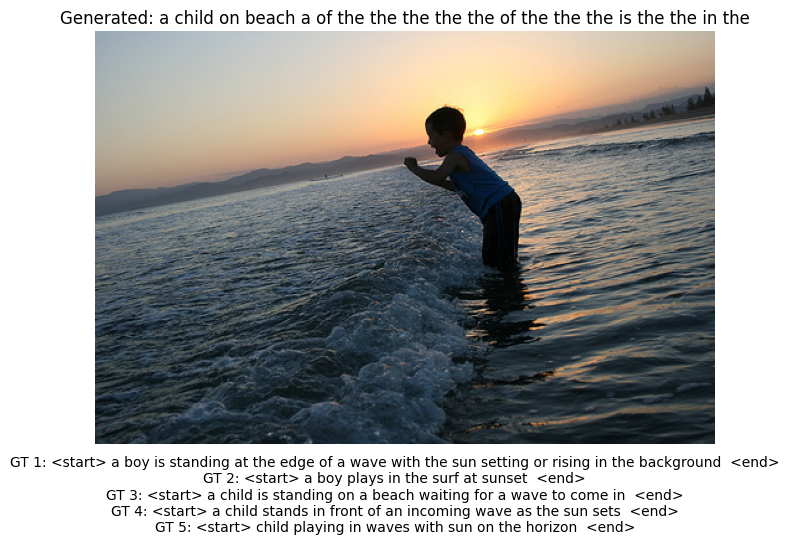

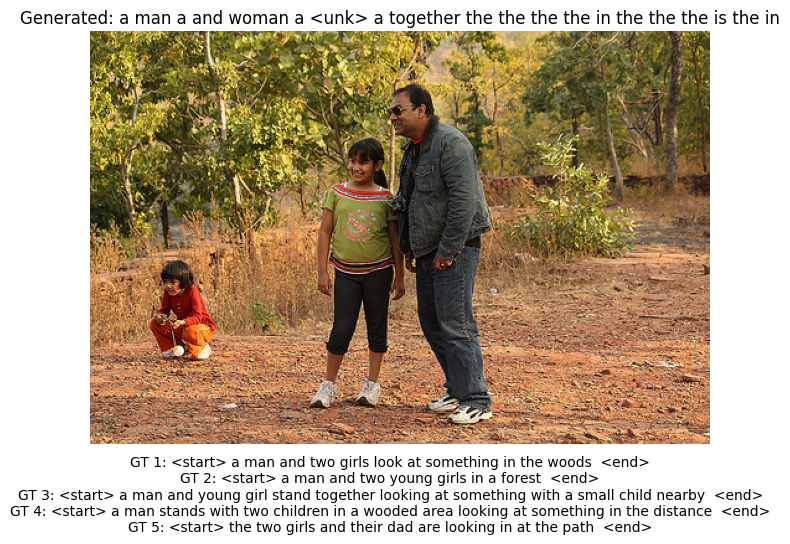

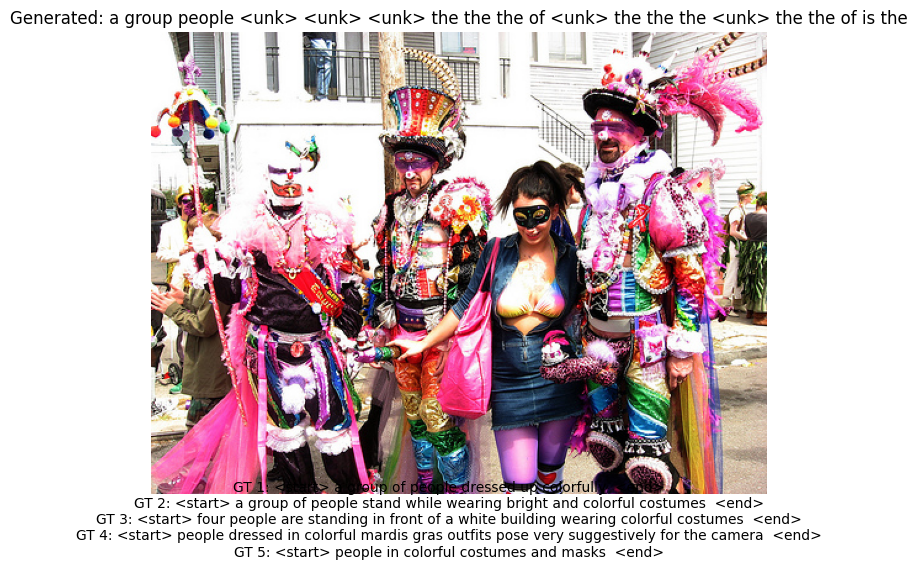

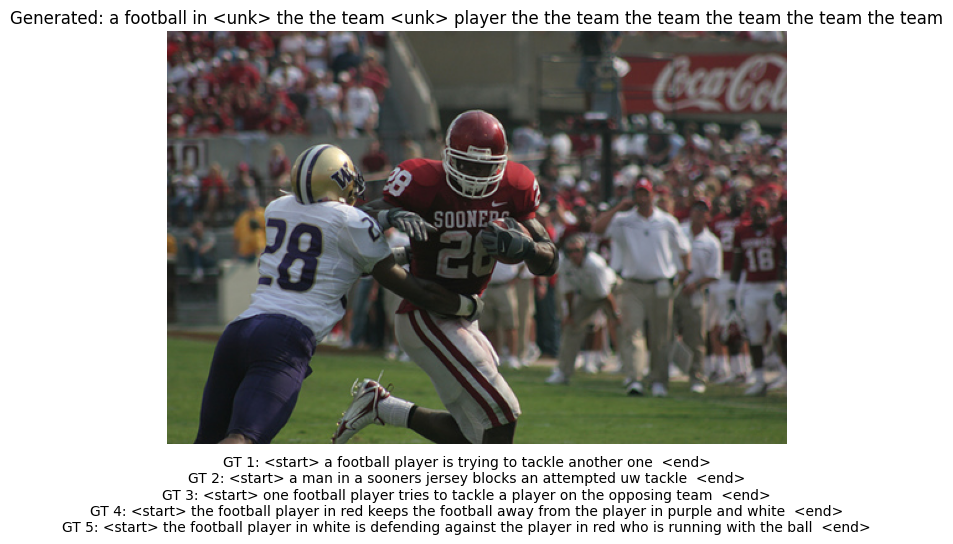

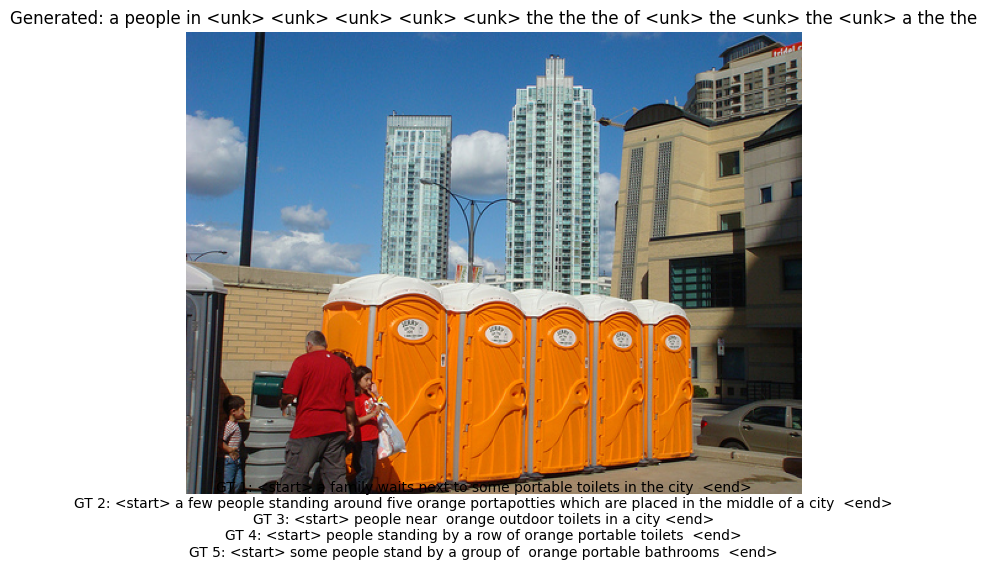


Evaluating BLEU on 50 random images:
Avg BLEU-1: 0.3560  |  Avg BLEU-4: 0.0000


In [14]:
#Check some outputs and BLEU score
display_random_captions(model, dataset, num_images=5)
evaluate_bleu(model, dataset, num_samples=50)
